In [20]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


data = pd.read_csv('/content/DailyDelhiClimateTest.csv')

# Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Handle missing or invalid dates
data = data.dropna(subset=['date'])  # Drop rows with invalid or missing dates

# Set 'date' as the index
data.set_index('date', inplace=True)

# Rename columns for consistency
if 'meantemp' in data.columns:
    data.rename(columns={'meantemp': 'temperature'}, inplace=True)

# Handle missing values in the 'temperature' column
data['temperature'] = data['temperature'].interpolate(method='time')

# Check if the dataset is clean
print(data.info())
print(data.describe())




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temperature   114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB
None
       temperature    humidity  wind_speed  meanpressure
count   114.000000  114.000000  114.000000    114.000000
mean     21.713079   56.258362    8.143924   1004.035090
std       6.360072   19.068083    3.588049     89.474692
min      11.000000   17.750000    1.387500     59.000000
25%      16.437198   39.625000    5.563542   1007.437500
50%      19.875000   57.750000    8.069444   1012.739316
75%      27.705357   71.902778   10.068750   1016.739583
max      34.500000   95.833333   19.314286   1022.809524


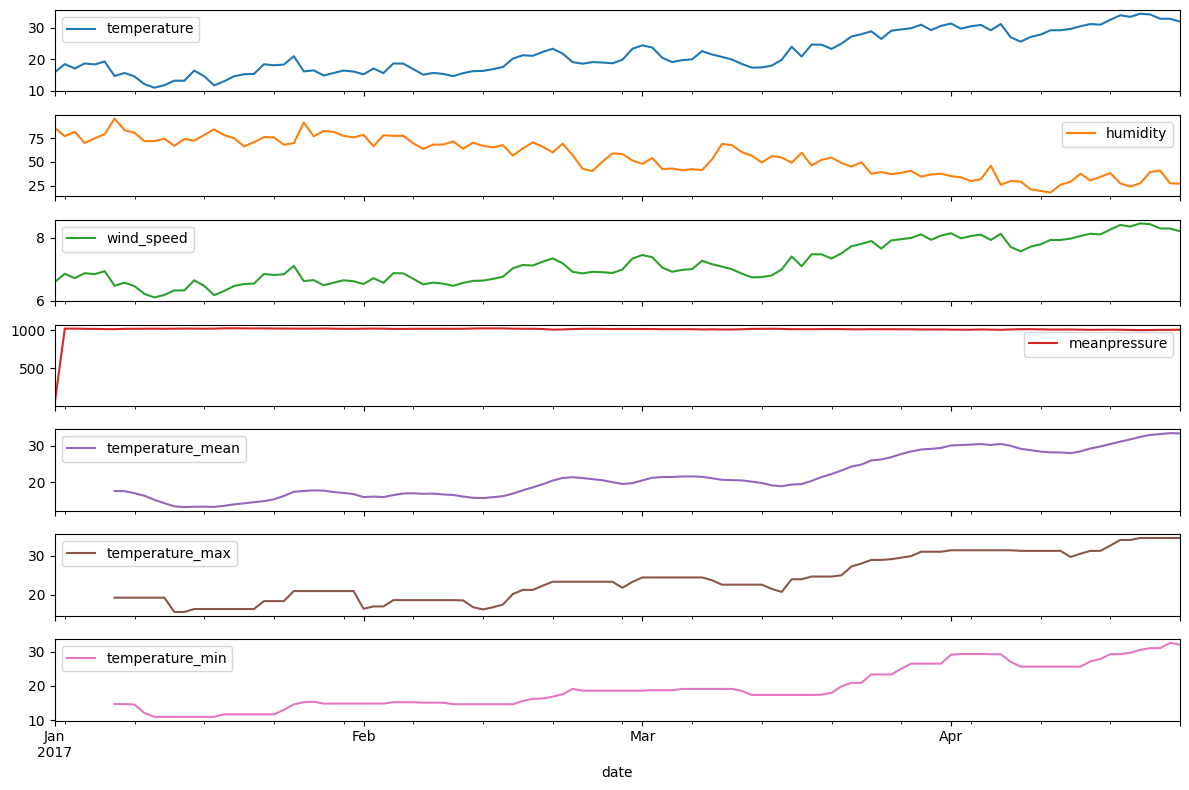

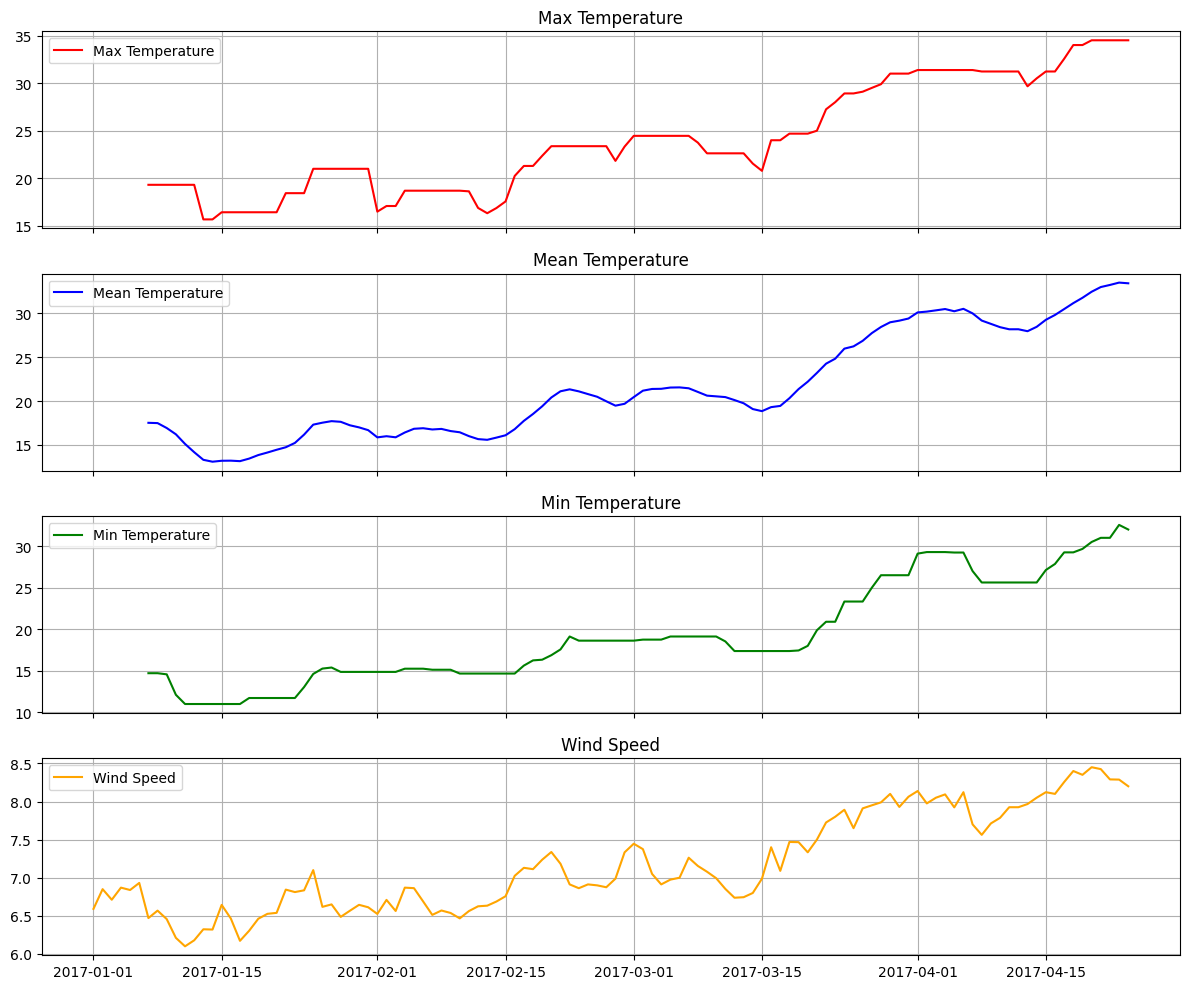

In [25]:
# Plot all variables
data.plot(subplots=True, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Generate rolling statistics for visualization
data['temperature_mean'] = data['temperature'].rolling(window=7).mean()
data['temperature_max'] = data['temperature'].rolling(window=7).max()
data['temperature_min'] = data['temperature'].rolling(window=7).min()

# Generate synthetic 'wind_speed' data for visualization (since it doesn't exist in the dataset)
data['wind_speed'] = data['temperature'] * 0.1 + 5

# Visualization: Subplots for derived variables
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axs[0].plot(data.index, data['temperature_max'], label='Max Temperature', color='red')
axs[0].set_title('Max Temperature')
axs[0].legend()
axs[0].grid()

axs[1].plot(data.index, data['temperature_mean'], label='Mean Temperature', color='blue')
axs[1].set_title('Mean Temperature')
axs[1].legend()
axs[1].grid()

axs[2].plot(data.index, data['temperature_min'], label='Min Temperature', color='green')
axs[2].set_title('Min Temperature')
axs[2].legend()
axs[2].grid()

axs[3].plot(data.index, data['wind_speed'], label='Wind Speed', color='orange')
axs[3].set_title('Wind Speed')
axs[3].legend()
axs[3].grid()

plt.tight_layout()
plt.show()

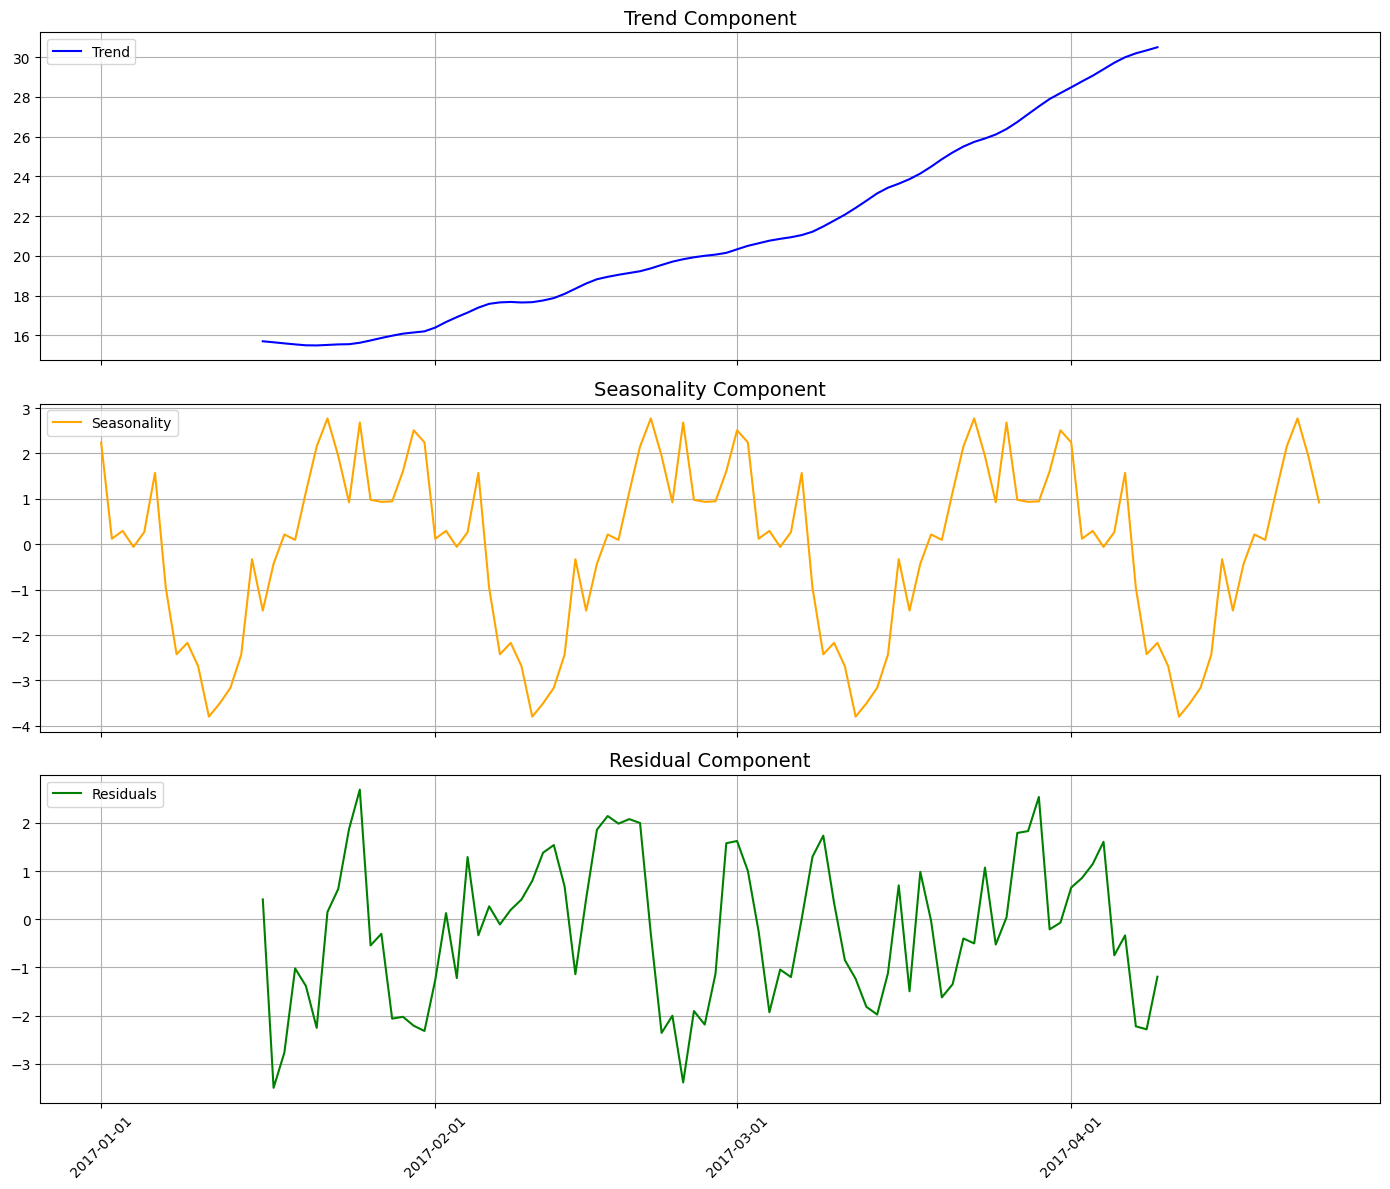

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

# Decompose the time series with the adjusted period (example using 30 days)
decomposition = seasonal_decompose(data['temperature'], model='additive', period=30)

# Plot decomposition
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot trend
axs[0].plot(decomposition.trend, label='Trend', color='blue')
axs[0].set_title('Trend Component', fontsize=14)
axs[0].legend(loc='upper left')
axs[0].grid()

# Plot seasonality
axs[1].plot(decomposition.seasonal, label='Seasonality', color='orange')
axs[1].set_title('Seasonality Component', fontsize=14)
axs[1].legend(loc='upper left')
axs[1].grid()

# Plot residuals
axs[2].plot(decomposition.resid, label='Residuals', color='green')
axs[2].set_title('Residual Component', fontsize=14)
axs[2].legend(loc='upper left')
axs[2].grid()

# Format x-axis with dates
plt.xticks(rotation=45)
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates
axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show ticks for every month

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [23]:

# Forecasting: Split dataset into training and testing sets
train = data[:int(0.8 * len(data))]
test = data[int(0.8 * len(data)):]

# Fit STL with ARIMA for Forecasting
stl = STLForecast(train['temperature'], ARIMA, model_kwargs={"order": (1, 1, 1)})
stl_fit = stl.fit()

# Forecast
forecast = stl_fit.forecast(steps=len(test))

# Evaluate Forecasting Performance
mae = mean_absolute_error(test['temperature'], forecast)
rmse = np.sqrt(mean_squared_error(test['temperature'], forecast))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 2.0668733463037214
Root Mean Squared Error (RMSE): 2.549473245581729


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
